# Building a Simple **MLP** for Classification

Step by step, the notebook explains:

- What an artificial neuron is and how it works  
- The role of **activation functions** (ReLU, Sigmoid, Softmax)  
- The idea of **loss functions** (Cross-Entropy) and the learning cycle  
- How to build a **Multi-Layer Perceptron (MLP)** from scratch using `NumPy`  
- Training on a simple 2‑D dataset and visualizing the **decision boundary** and **loss curve**

> The goal is to build intuition, not a production-grade model.


## 1) Artificial Neurons and Activation Functions

A neuron combines its inputs $ x$  with weights $ w$, adds a bias $b$, forming:

$$
z = w^T x + b
$$

Then it passes $ z$ through an **activation function**:

- **ReLU:** $ \max(0, z) $ — simple and effective for hidden layers  
- **Sigmoid:** outputs values in (0,1); often used for binary classification  
- **Softmax:** converts a vector of values into probabilities that sum to 1 (used for multi‑class output)

Without a non‑linear activation, even deep networks would learn only **linear** relationships.


## 2) Loss Function & Learning Cycle

For classification, we use **Cross‑Entropy Loss**.

Training loop:

1. **Forward pass:** compute model predictions  
2. **Compute loss**  
3. **Backward pass:** compute gradients (Backpropagation)  
4. **Update weights** using gradient descent  

Repeat for many **epochs** until the model learns.


In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # Reproducibility


## 3) Creating a Simple Synthetic Dataset

We'll build a small 2‑D dataset with two Gaussian clusters (binary classification).


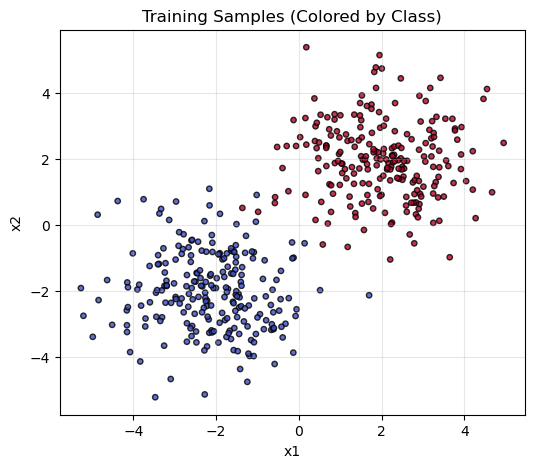

In [7]:
# Create two Gaussian blobs
def make_blobs(n_per_class=200, spread=1.2):
    mean0 = np.array([-2.0, -2.0])
    mean1 = np.array([ 2.0,  2.0])
    cov = np.array([[spread, 0.0],[0.0, spread]])
    X0 = np.random.multivariate_normal(mean0, cov, n_per_class)
    X1 = np.random.multivariate_normal(mean1, cov, n_per_class)
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)])
    return X, y

X, y = make_blobs(n_per_class=300, spread=1.5)

# Train/test split
indices = np.arange(len(X))
np.random.shuffle(indices)
train_ratio = 0.75
split = int(train_ratio * len(X))
train_idx, test_idx = indices[:split], indices[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]
# Plot sample points with color based on class
plt.figure(figsize=(6, 5))
plt.scatter(
    X_train[:, 0], X_train[:, 1],
    c=y_train,           # color by class label (0 or 1)
    cmap='coolwarm',     # color map: blue–red
    s=15,                # point size
    alpha=0.8,           # transparency for better visibility
    edgecolors='k'       # black edge around points for clarity
)

plt.title("Training Samples (Colored by Class)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True, alpha=0.3)
plt.show()


## 4) Implementing an MLP from Scratch (NumPy)

Architecture: **2 → (H) → 1**

- Hidden layer: **ReLU**
- Output layer: **Sigmoid** (binary probability)
- Loss: **Binary Cross‑Entropy**


In [3]:
# Activation functions
def relu(z):
    return np.maximum(0, z)

def relu_grad(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Loss & accuracy
def bce_loss(y_true, y_pred, eps=1e-12):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1 - y_pred))

def accuracy(y_true, y_pred_prob):
    y_pred = (y_pred_prob >= 0.5).astype(int)
    return (y_pred == y_true).mean()

# MLP class
class MLP:
    def __init__(self, in_dim=2, hidden=8, out_dim=1):
        self.W1 = 0.01 * np.random.randn(in_dim, hidden)
        self.b1 = np.zeros((1, hidden))
        self.W2 = 0.01 * np.random.randn(hidden, out_dim)
        self.b2 = np.zeros((1, out_dim))

    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        h1 = relu(z1)
        z2 = h1 @ self.W2 + self.b2
        yhat = sigmoid(z2)
        cache = (X, z1, h1, z2, yhat)
        return yhat, cache

    def backward(self, cache, y_true):
        X, z1, h1, z2, yhat = cache
        N = X.shape[0]
        y_true = y_true.reshape(-1,1)

        dL_dz2 = (yhat - y_true)

        dW2 = (h1.T @ dL_dz2) / N
        db2 = dL_dz2.mean(axis=0, keepdims=True)

        dh1 = dL_dz2 @ self.W2.T
        dz1 = dh1 * relu_grad(z1)

        dW1 = (X.T @ dz1) / N
        db1 = dz1.mean(axis=0, keepdims=True)

        grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
        return grads

    def step(self, grads, lr=0.1):
        self.W1 -= lr * grads["dW1"]
        self.b1 -= lr * grads["db1"]
        self.W2 -= lr * grads["dW2"]
        self.b2 -= lr * grads["db2"]


## 5) Training the Model — Tracking Loss and Accuracy


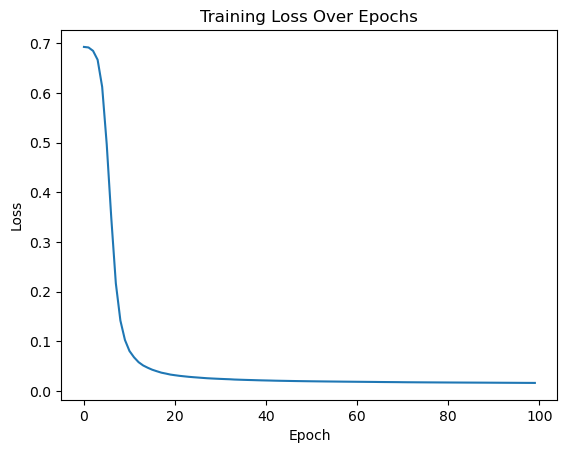

Train accuracy: 0.9933
Test  accuracy: 0.9867


In [18]:
mlp = MLP(in_dim=2, hidden=5, out_dim=1)
epochs = 100
lr = 0.1
batch_size = 64

loss_hist = []
acc_hist  = []

N = len(X_train)
for ep in range(1, epochs+1):
    perm = np.random.permutation(N)
    X_train_shuf = X_train[perm]
    y_train_shuf = y_train[perm]

    for i in range(0, N, batch_size):
        xb = X_train_shuf[i:i+batch_size]
        yb = y_train_shuf[i:i+batch_size]

        yhat, cache = mlp.forward(xb)
        loss = bce_loss(yb, yhat.squeeze())
        grads = mlp.backward(cache, yb)
        mlp.step(grads, lr=lr)

    yhat_train, _ = mlp.forward(X_train)
    loss_epoch = bce_loss(y_train, yhat_train.squeeze())
    acc_epoch  = accuracy(y_train, yhat_train.squeeze())
    loss_hist.append(loss_epoch)
    acc_hist.append(acc_epoch)

# Plot loss curve
plt.figure()
plt.plot(loss_hist)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Final accuracy
yhat_test, _ = mlp.forward(X_test)
print("Train accuracy:", round(accuracy(y_train, yhat_train.squeeze()), 4))
print("Test  accuracy:", round(accuracy(y_test,  yhat_test.squeeze()), 4))


## 6) Visualizing the Decision Boundary


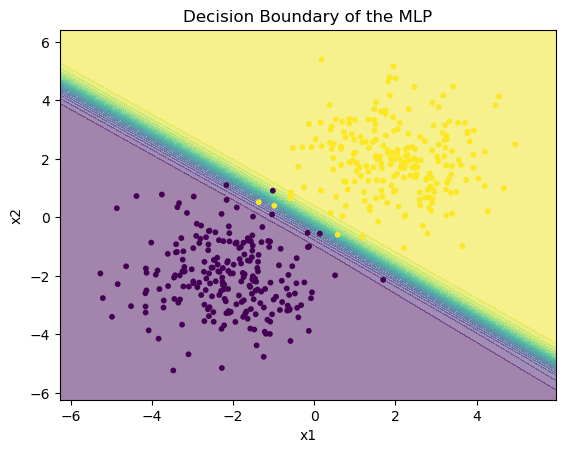

In [17]:
def plot_decision_boundary(model, X, y, steps=200, padding=1.0):
    x_min, x_max = X[:,0].min()-padding, X[:,0].max()+padding
    y_min, y_max = X[:,1].min()-padding, X[:,1].max()+padding
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, steps),
        np.linspace(y_min, y_max, steps)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs, _ = model.forward(grid)
    Z = probs.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, levels=20, alpha=0.5)
    plt.scatter(X[:,0], X[:,1], c=y, s=10)
    plt.title("Decision Boundary of the MLP")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

plot_decision_boundary(mlp, X_train, y_train)


## 7) Important Concepts: Overfitting, Validation, Early Stopping

- If training loss decreases but performance on unseen data is poor → **overfitting**.
- Solutions: simpler model, more diverse data, dropout, early stopping.
- Always keep a **validation** and **test** set to evaluate generalization.


## 8) Suggested Exercises

1. Change the hidden layer size (`hidden`) to 2, 4, 16 — how does the decision boundary change?  
2. Play with the learning rate (`lr`) — how does convergence change?  
3. Replace ReLU with `tanh` and compare performance.  
4. Move the Gaussian means closer so the problem becomes harder.  


## Appendix: Using `tanh` Instead of ReLU


In [6]:
# Optional activation function
def tanh(z):
    return np.tanh(z)

def tanh_grad(z):
    return 1 - np.tanh(z)**2

# To use:
# Replace in forward():
#     h1 = tanh(z1)
# Replace in backward():
#     dz1 = dh1 * tanh_grad(z1)
